# CS 4496/7496 Character Animation (Spring 2020)
Copyright (c) Georgia Institute of Technology


---


## Project 3: Tinkertoy (due 3/6/2020, 11:55PM)

![TinkerToy Picture](http://sehoonha.com/images/tinkertoy.png)

Your task is to simulate two beads under gravity. One bead must stay on a circular wire and the second bead is connected to the first one by a fixed-length rod. You will implement one constraint that keeps a bead on the circle and another that keeps two beads a fixed distance apart. Your program should simulate the motion of the beads under gravity and should draw the beads as they move. 

**Reference: 04_ConstrDyn.pdf (1p ~ 36p)**

In [0]:
# import necessary libraries
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# 1. Constrained system
Define the initial state of the system, which consists of the positions and velocities of the two beads. The first bead is at (0.6, 0.8) initially, and attached to a circle of radius 1, centered at the origin. The second bead is at (0.6, 0.3) initially, connected to the first bead by a rod of length 0.5. Both particles have zero initial velocity.

In [0]:
# number of beads in the system
n_particles = 2

# number of constraints in the system
n_constraints = 2

positions, velocities = None, None # placeholders
constraint_values = list()

def initialize():
  global positions, velocities, constraint_values
  # positions: column vector of size 2 * n_particles, concatenation of all positions of the beads
  positions = np.array([0.6, 0.8, 0.6, 0.3]).reshape(-1, 1)
  # velocities: column vector of size 2 * n_particles, concatenation of all velocities of the beads
  velocities = np.array([0., 0., 0., 0.]).reshape(-1, 1)
  # constraint_values: a list of constraint values over time
  constraint_values = list()

Given the positions and velocities of the particles, evaluate the value of constraints, C(x), and time derivative of it, Cdot(x). These values are used in the calculation of feedback terms. ** **write your code below (15 pts each)**  **

In [0]:
def eval_C(positions, velocities):
  """Evaluates the value of constraints, C."""
  C = np.zeros([n_constraints, 1])
  # Student code starts here
  pos1 = positions[0:2]
  pos2 = positions[2:4]
  r = 1
  d = 0.5

  c1 = np.vdot(pos1, pos1) * 0.5 - 0.5 * (r ** 2)
  c2 = np.vdot(pos1 - pos2, pos1 - pos2) * 0.5 - 0.5 * (d ** 2)

  C = np.array([[c1], [c2]])
  # Student code ends here
  return C

In [0]:
def eval_Cdot(positions, velocities):
  """Evaluates the time derivative of constraints, Cdot."""
  Cdot = np.zeros([n_constraints, 1])
  # Student code starts here
  vel1 = velocities[0:2,:]
  vel2 = velocities[2:4,:]
  pos1 = positions[0:2,:]
  pos2 = positions[2:4,:]

  Cdot = np.array([vel1.T @ pos1, (vel1 - vel2).T @ (pos1 - pos2)]).reshape(-1, 1)

  # Student code ends here
  return Cdot

The below is the simple unit test. The test is design to verify whether 1) C and Cdots are zero when it is at the valid state and 2) C and Cdots are non zero when we perturb the state. Can you pass the tests?

In [0]:
# Simple unit tests
p0, v0 = np.array([0.6, 0.8, 0.6, 0.3]).reshape(-1, 1), np.array([0.0, 0.0, 0.0, 0.0]).reshape(-1, 1)
assert(np.allclose(eval_C(p0, v0), np.array([[0.0], [0.0]])))
assert(not np.allclose(eval_C(p0 + 0.1, v0), np.array([[0.0], [0.0]])))
assert(np.allclose(eval_Cdot(p0, v0), np.array([[0.0], [0.0]])))
assert(not np.allclose(eval_Cdot(p0, v0 + 0.1), np.array([[0.0], [0.0]])))


For simplicity, the mass of the beads are all set to 1. Mass matrix and inverse mass matrix are simply identity matrices of size 2 * n_particles.

In [0]:
M = np.eye(n_particles * 2)  
W = np.eye(n_particles * 2)  

The external forces in this system are gravities on the beads. The external force vector is defined below.

In [7]:
g = -10
Q = M @ np.tile([0, g], n_particles).reshape(-1, 1)
print("The external force vector = \n", Q)

The external force vector = 
 [[  0.]
 [-10.]
 [  0.]
 [-10.]]


Here, evaluate the value of the Jacobian matrix and its time derivative. Complete the code below. (hint: what are the dimenions of each matrix?) ** **write your code below (15 pts each)**  **

In [0]:
def eval_J(positions, velocities):
  """Evaluates the value of the Jacobian matrix, J."""
  # Student code starts here
  J = np.zeros((n_constraints, n_particles * 2))
  J[0,0:2] = positions[0:2,:].reshape(1,2)
  J[0,2:4] = [0, 0]
  x1x2 = (positions[0:2,:] - positions[2:4, :])     
  x2x1 = (positions[2:4,:] - positions[0:2, :]) 
  J[1,0:2] = x1x2.reshape(1,2)
  J[1,2:4] = x2x1.reshape(1,2)
  # Student code ends here
  return J

In [0]:
def eval_Jdot(positions, velocities):
  """Evaluates the time derivative of the Jacobian matrix, Jdot."""
  # Student code starts here
  Jdot = np.zeros((n_constraints, n_particles * 2))
  Jdot[0,0:2] = velocities[0:2,:].reshape(1,2)
  Jdot[0,2:4] = [0, 0]
  Jdot[1,0:2] = (velocities[0:2,:]-velocities[2:4,:]).reshape(1,2)
  Jdot[1,2:4] = -(velocities[0:2,:]-velocities[2:4,:]).reshape(1,2)
  # Student code ends here
  return Jdot

Let's see if your codes can pass the unit test. By definition, J is a partial derivative of C with respect to x and Jdot is a partial derivative of Cdot with respect to x. The below test computes J and Jdot using numerical approximation (https://en.wikipedia.org/wiki/Finite_difference) and compares with your implementation. Please use this part as a sanity check for your previous functions.

In [0]:
# Unit tests for J and Jdot
# By the definition, J is a partial derivative of C.
# And Jdot is a partial derivative of Cdot.
# Can we check them with a numerical approximation method?
p0, v0 = np.array([0.6, 0.8, 0.6, 0.3]).reshape(-1, 1), np.array([0.0, 0.0, 0.0, 0.0]).reshape(-1, 1)
h = 0.001
J = eval_J(p0, v0)
Jdot = eval_Jdot(p0, v0)
assert(J.shape == (n_constraints, n_particles * 2))
assert(Jdot.shape == (n_constraints, n_particles * 2))

for i in range(n_particles * 2):
  delta = np.zeros([n_particles * 2, 1])
  delta[i, 0] = h

  # Perturb the i th element of p0 by h
  Cm = eval_C(p0 - delta, v0)
  Cp = eval_C(p0 + delta, v0)
  dC_dpi = (Cp - Cm) / (2 * h) # Numerical approximation with finite difference
  test =  J[:, i].reshape(-1, 1)
  assert(np.allclose(dC_dpi, J[:, i].reshape(-1, 1)))

  # Perturb the i th element of p0 by h
  Cdotm = eval_Cdot(p0 - delta, v0)
  Cdotp = eval_Cdot(p0 + delta, v0)
  dCdot_dpi = (Cdotp - Cdotm) / (2 * h) # Numerical approximation with finite difference
  assert(np.allclose(dCdot_dpi, Jdot[:, i].reshape(-1, 1))) 

Find the derivatives of positions and velocities of all particles at the current frame. You need to calculate 1) the Lagrangian multipliers with feedback terms and 2) the forces due to constraints, and then 3) the derivatives of positions and velocities of the particles. (hint: keep checking dimensions of each component, the Lagrangian multipliers, constraint forces, and so on) (hint #2: what are the definitions of positions and velocities?) ** **write your code below (15 pts)**  **

In [0]:
def eval_derivative(positions, velocities):
  global M, W, Q
  C = eval_C(positions, velocities)
  Cdot = eval_Cdot(positions, velocities)
  J = eval_J(positions, velocities)
  Jdot = eval_Jdot(positions, velocities)

  positions_derivative = np.zeros(positions.shape)
  velocities_derivative = np.zeros(velocities.shape)

  # Feedback terms parameters
  # You can tune these values
  ks = 1
  kd = 1


  # Student code starts here
  
  # 1) Compute the Lagrangian multipliers w/ feedback terms 
  x = np.transpose(J)
  left = J.dot(W).dot(x)
  right = -Jdot.dot(velocities) - J.dot(W).dot(Q) - ks*C - kd * Cdot
  inver = np.linalg.inv(left)
  lam = inver.dot(right)

  # 2) Compute the constraint forces
  consf = x.dot(lam)

  # 3) Compute the position and velocity derviatives.
  positions_derivative = velocities
  velocities_derivative = W.dot(Q+consf) 

  # Student code ends here
  assert(positions_derivative.shape == positions.shape)
  assert(velocities_derivative.shape == velocities.shape)
  return positions_derivative, velocities_derivative


Now we need the integrators.
The explicit Euler integration method is given.
Your task is to complete the Midpoint method.
** **write your code below (10 pts)**  **

In [0]:


def explicit_euler(dt):
  """Advances the positions and velocities by dt using the Euler method."""
  global positions, velocities
  # modifies positions, velocities
  dp, dv = eval_derivative(positions, velocities)
  positions += dt * dp
  velocities += dt * dv
  
def mid_point(dt):
  """Advances the positions and velocities by dt using the Midpoint method."""
  global positions, velocities
  # modifies positions, velocities
  # student code starts here
  dp, dv = eval_derivative(positions,velocities)

  midp = positions + (dt/2) * dp
  midv = velocities + (dt/2) * dv

  dp2, dv2 = eval_derivative(midp, midv)
  positions = positions + dt * dp2
  velocities = velocities + dt * dv2

  # student code ends here

def RK4(dt):
  """Advances the positions and velocities by dt using the Midpoint method."""
  global positions, velocities
  # modifies positions, velocities
  # student code starts here
  dp1, dv1 = eval_derivative(positions,velocities)
  k1p = dt * dp1
  k1v = dt * dv1

  dp2, dv2 = eval_derivative(positions + k1p/2, velocities + k1v/2)
  k2p = dt * dp2
  k2v = dt * dv2

  dp3, dv3 = eval_derivative(positions + k2p/2, velocities + k2v/2)
  k3p = dt * dp3
  k3v = dt * dv3

  dp4, dv4= eval_derivative(positions + k3p, velocities + k3v)
  k4p = dt * dp4
  k4v = dt * dv4

  positions = positions + k1p/6 + k2p/3 + k3p/3 + k4p/6
  velocities = velocities + k1v/6 + k2v/3 + k3v/3 + k4v/6

  # student code ends here

def update(dt):
  global positions, velocities, constraint_values
  # change this line if you use midpoint
  # explicit_euler(dt)
  mid_point(dt)
  # RK4(dt)

  # record the constraint values
  C = eval_C(positions, velocities)
  constraint_values.append(C.reshape(-1))


Function calls for creating animations. Do not modify this part (unless you are working on extra questions).

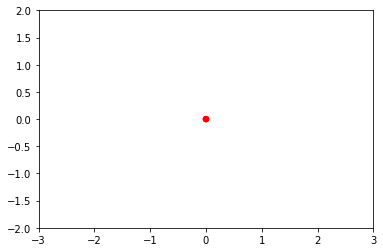

In [13]:
n = n_particles
# Figure and shape placeholders
fig, ax = plt.subplots()
ax.set_xlim((-3.0, 3.0))
ax.set_ylim((-2.0, 2.0))
circle, = ax.plot([], [], 'b')
rod, = ax.plot([], [], 'k')
beads = []
for i in range(n):
  bead = plt.Circle((0, 0), 0.05, color='r')
  beads.append(bead)
  ax.add_artist(bead)

# plot circle, rod and beads
def plot_scene():
  circle.set_data(np.cos(np.linspace(0, 2*np.pi, 100)), np.sin(np.linspace(0, 2*np.pi, 100)))
  rod.set_data([positions[0], positions[2]], [positions[1], positions[3]])
  for i in range(n):
    beads[i].set_center(positions[2*i:2*i+2])

# Called before the first frame
def init_animation():
  plot_scene()
  return []

# Called every frame
def animate(i):
  if i % 25 == 0:
    print("Generating frame #%d..." % i)
  update(0.01)
  plot_scene()
  return []




Generate your animation!

In [14]:
initialize()
anim = animation.FuncAnimation(fig, animate, init_func=init_animation, frames=500, interval=20, blit=False)
HTML(anim.to_html5_video())

Generating frame #0...
Generating frame #25...
Generating frame #50...
Generating frame #75...
Generating frame #100...
Generating frame #125...
Generating frame #150...
Generating frame #175...
Generating frame #200...
Generating frame #225...
Generating frame #250...
Generating frame #275...
Generating frame #300...
Generating frame #325...
Generating frame #350...
Generating frame #375...
Generating frame #400...
Generating frame #425...
Generating frame #450...
Generating frame #475...


Let's plot both constraint values. Are they near zero during the entire simulation?

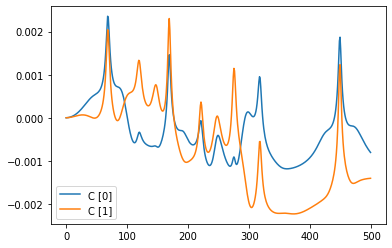

In [15]:
constraint_values = np.array(constraint_values)
plt.plot(constraint_values[:, 0], label="C [0]")
plt.plot(constraint_values[:, 1], label="C [1]")
plt.legend()

Now it's time for discussion. Repeat the experiments with different integrators (Euler/Midpoint) and different feedback terms (ks/kd). Discuss their effects on simulation. What is the best method so far? ** **write your answer below (15 pts)** **

I first tested the experiement with Euler and Midpoint integrator, separately. 
[Euler](https://drive.google.com/open?id=1io6DSwMbZzhzzYwvub1jZ_4zcTDRkMRP) and [Midpoint](https://drive.google.com/open?id=1Tdx7lfSPI5rD_BpcM43htNQNZSaQpMWI) shows the result. Based on animation, simulation based on Midpoint method, the first bead will consistenly stay on the wire and the second bead keeps staying within a constant distance from the first bead. And the plots of contrains are all damped around 0. For Eular method, the simulation animation indicates that the first bead sometimes would go off the wire and the distance between two beads varies as well. At some time point, the whole system just broke out. So that the contraint plot still shows the vibration around 0, but the breakup at sigularity point has large effect to the graph that directly goes to infinite. 

Then, I tested how ks and kd would affect the system.

[ks = 0, kd = 0](https://drive.google.com/open?id=1OqIYDtkflAUoj1Firwp4cUICVWcI5ZJR) | [ks = 5, kd = 1](https://drive.google.com/open?id=14v9AmX-Y153rbUybS4dxbrLr_oU9RD59) | [ks = 800, kd = 1](https://drive.google.com/open?id=1vOYgnXhdQT2v0rIzeVqlWbQSg__5A1AF) | [ks = 1, kd = 10](https://drive.google.com/open?id=1-e7wjr8tFJEwGq6Fk4IrdCivQ29gXTth) | [ks = 1, kd =180](https://drive.google.com/open?id=1LegZMTs4t_x5r-z-kKppgASI8W_CaDaq)

When kd and ks are all zeros, there is no feedback in this system. We can see from the graph that both constrians are keeping decresing. Thus, we can predict that if our time frame is longer, the system would not be stable. Then we increases the spring coefficient and damping coefficient separately. While we keep ks but increaing kd, position contrainst still varies around 0, white velocity contraint stablize around a value is greater than 0. However, if we keep kd but increase ks, both constraints will still stablize around 0, but as ks is creasing, the frequency of oscillation will increase a lot. 


# 2. Extra points

**(Note: when you edit the above code, make sure that the instructors can run the entire notebook by clicking the "restart and run all" button.)**

2.1. Apply extra forces a few times during the simulation. Don't forget to visualize the forces as lines. You are expected to directly modify the above code (hint: update the global force vector Q with respect to time. You can modify either update or animate functions). ** **edit the above code directly and explain your implmenetation below (2 pts)**  **


(explain your implementation here)

2.2. Implement the RK4 solver and verify that it is better than other methods. ** **edit the above code directly and explain your implmenetation below (3 pts)**  **

To implement RK4, please comment the "mid_point(dt)" in line 57, and comment out "RK4(dt)" in line 58 of the integrator secton.


Here is the plot for using RK4: [RK4](https://drive.google.com/open?id=17bwTVCYyr1qwom0uiti_YojtAkbZzKKg)

From the plot we can say RK4 is better than the other method, since it significantly decrease the vibration. 


2.3. Implement additional types of constraints for the tinkertoy (e.g. an additional bead is connected to the second bead or three beads should always form an equilateral triangle). If the constraint outputs more than a single scalar, you need to modify the indexing scheme for the global matrices and vectors so that the constraint evaluations and derivatives are stored in the correct places. (hint: here's an inspiring example: https://youtu.be/ShtiCeJWIxw) ** **edit the above code directly and explain your implmenetation below (5 pts)**  **

(explain your implementation here)